In [146]:
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from scipy.stats import norm

In [209]:
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

# Распознавание образов, описываемых гауссовскими случайными векторами с одинаковыми матрицами ковариаций 

Рассмотрим случай распознавания образов, описываемых двумерными гауссовскими случайными векторами с одинаковыми матрицами ковариации 
$$C = 
\begin{bmatrix}
    5 & -1 \\
    -1 & 4
\end{bmatrix}
$$

Пусть образы могут принадлежать одному из $M = 3$ классов, а матожидания и дисперсии случайных векторов равны

$$
\vec{m_{1}} = 
\begin{bmatrix}
    -2\\
     3
\end{bmatrix},\,
\vec{m_{2}} = 
\begin{bmatrix}
     10\\
     1
\end{bmatrix},\,
\vec{m_3} = 
\begin{bmatrix}
     4\\
     -1
\end{bmatrix}
\\
\vec{d} = 
\begin{bmatrix}
     5\\
     4
\end{bmatrix}
$$

Априорные вероятности появления объекта $i$-го класса считаем равными:
$$
p(\omega_1) = p(\omega_2) = p(\omega_3) = \dfrac{1}{3}
$$

In [182]:
M = 3

n = 2

m1 = np.array((-2, 3))
m2 = np.array((10, 1))
m3 = np.array((4, -1))

D1 = 5
D2 = 4

C = np.matrix([(5, -1),(-1, 4)])

Визуализируем функции плотности вероятностей случайных векторов трех классов:

In [184]:
xMin = m[0, :].min() - 4*np.sqrt(D1)
xMax = m[0, :].max() + 4*np.sqrt(D1)
yMin = m[1, :].min() - 4*np.sqrt(D2)
yMax = m[1, :].max() + 4*np.sqrt(D2)

def drawPdf(plot):
    x, y = np.mgrid[xMin:xMax:0.05, yMin:yMax:0.05]
    pos = np.dstack((x, y))
    
    for i in range(0, M):
        rv = multivariate_normal(m[:, i], C)
        plot.contour(x, y, rv.pdf(pos))

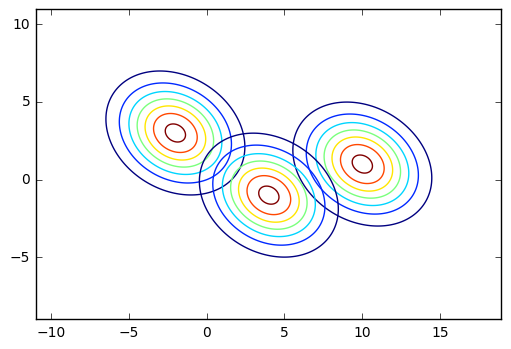

In [188]:
fig = plt.figure()

ax = fig.add_subplot(111)

drawPdf(ax)

plt.show();
plt.clf()

График представляет собой линии уровня поверхностей плотностей распределения случайных векторов. Чем выше уровень, тем больше вероятность реализации случайного вектора с данными координатами

Сформируем по $ n = 400$ случайных величин каждого класса и отобразим их на графике:

In [198]:
n = 400

def gen(m, C, n):

    vals = np.zeros((M, 2, n))
    for i in range(0, M):
        rv = multivariate_normal(m[:, i], C)
        for j in range(0, n):
            x, y = rv.rvs()
            vals[i, 0:2, j] = rv.rvs()
            
    return vals

def drawPoints(points, plot):
    
    colors = ['r', 'g', 'b']
    
    for i in range(0, M):
        plot.scatter(points[i, 0, :], points[i, 1, :], c=colors[i], s=10)

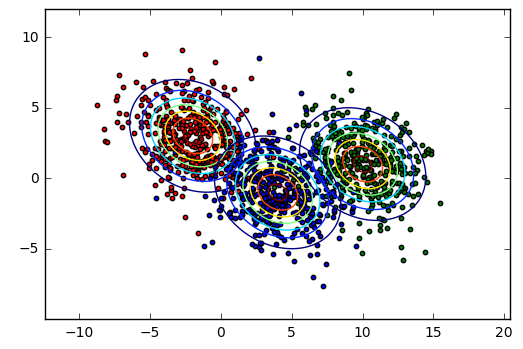

In [200]:
fig = plt.figure()

ax = fig.add_subplot(111)

vals = gen(m, C, n)

drawPoints(vals, ax)
drawPdf(ax)

plt.show()
plt.clf()

Действительно, чем больше плотность распределения в некоторой области, тем выше вероятность реализации случайного вектора этого класса в данной области

# Синтез алгоритма

Воспользуемся разделяющей функцией вида 
\begin{align}
g_i(\vec{x}) = ln(p(\omega_i)p(\vec{x} / \omega_i)),
\end{align}

где $p(\omega_i)$ - априорная вероятность появления объекта $i$-го класса, а $p(\vec{x} / \omega_i)$ - плотность распределения случайного вектора, описывающего объекты данного класса.

Подставив явный вид $p(x / \omega_i)$ и произведя упрощения, получим

\begin{align}
g_i(\vec{x}) = -\dfrac{1}{2}ln|C| - \dfrac{1}{2}\vec{x}^{\,T}C^{-1}\vec{x} + \vec{x}^{\,T}C^{-1}\vec{m_i} - \dfrac{1}{2}\vec{m_i}^{\,T}C^{-1}\vec{m_i} + ln(p(\omega_i)), \quad i=\overline{1, M}
\end{align}

При рассмотрении случайного вектора $\vec{x}$ будем считать, что он принадлежит $i$-му классу, если

\begin{equation}
    g_i(\vec{x}) \geqslant g_j(\vec{x}) \quad \forall j = \overline{1, M}, \quad j \neq i
\end{equation}

С учетом этого, из $g_i(\vec{x})$ можно исключить первые два слагаемых, так как они одинаковы для всех $g_i(\vec{x})$ и не влияют на неравенство.

Таким образом, имеем разделяющую функцию 
\begin{align}
g_i(\vec{x}) = \vec{x}^{\,T}C^{-1}\vec{m_i} - \dfrac{1}{2}\vec{m_i}^{\,T}C^{-1}\vec{m_i} + ln(p(\omega_i)), \quad i=\overline{1, M}
\end{align}

Данная функция линейная, и задает плоскость в трехмерном пространстве.

Упрощенно ее можно представить в виде 
\begin{align}
g_i^{'}(\vec{x}) = \vec{x}^{\,T}\vec{k_i} + b_i, \quad i=\overline{1, M},
\end{align}
где 
\begin{align}
\vec{k_i} = C^{-1}\vec{m_i}, \quad b_i = - \dfrac{1}{2}\vec{m_i}C^{-1}\vec{m_i} + ln(p(\omega_i)), \quad i=\overline{1, M}
\end{align}

Определим матрицу $G$ вида
$$
G = 
\begin{bmatrix}
    k_1^{1}&k_2^{1}&b^{1}\\
    k_1^{2}&k_2^{2}&b^{2}\\
    k_1^{3}&k_2^{3}&b^{3}\\
\end{bmatrix}
$$
где по строкам распологаются координаты $\vec{k_i}, b_i$. Тогда, определив вектор 
$$
\vec{x^{'}} = 
\begin{bmatrix}
    x_1\\
    x_2\\
    1\\
\end{bmatrix},
$$ имеем:

$$
\vec{x}^{\,T}G = 
\begin{bmatrix}
    g_1(\vec{x})\\
    g_2(\vec{x})\\
    g_3(\vec{x})\\
\end{bmatrix},
$$

Тогда вектор $\vec{x}$ будет считаться принадлежащим к $i$-му классу, где $i$ - индекс максимального элемента в данном векторе.

Найдем матрицу $G$:

In [201]:
C_ = C**-1
G = np.zeros((M, 3))

col = np.array([[1], [2]])
row = np.array([1, 2])

for i in range(0, M):
    G[i, 0:2] = (C_.dot(m[:, [i]])).transpose()
    G[i, 2] = -0.5 *m[:, i].dot(C_).dot(m[:, [i]])
    

Уравнение $g_i(\vec{x}) = g_j(\vec{x})$ задает прямую, разделяющую векторы $i$ и $j$ класса.

Отобразим три данные прямые вместе с графиком плотностей распределения:

In [205]:
def drawLines(plot):
    i_ = np.array([1, 0])
    j_ = np.array([0, 1])

    for i in range(0, M):
        for j in range(i+1, M):
            
            A = C_.dot(m[:, [i]] - m[:, [j]])
            B = -0.5*(m[:, i] + m[:, j]) * C_ * (m[:, [i]] - m[:, [j]]) - np.log(1)
            
            k = -A.item(0) / A.item(1)
            b = -B.item(0) / A.item(1)

            y1 = k*xMin + b
            y2 = k*xMax + b

            #ax = fig.add_subplot(111)
            ax.plot([xMin, xMax], [y1, y2])
            ax.axis((xMin, xMax, yMin, yMax))

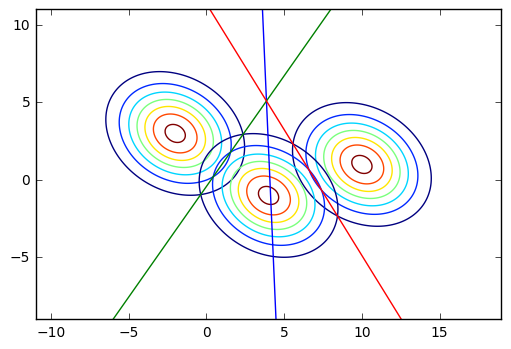

In [206]:

fig = plt.figure()
ax = fig.add_subplot(111)

drawLines(ax)

drawPdf(ax)

plt.show()
plt.clf()

По графику видно, что данные прямые действительно попарно разделяют различные классы

# Статистические испытания

Для каждого класса сформируем $k = 5000$ случайных векторов и выполним распознавание с помощью синтезированного алгоритма.
Построим матрицу ошибок $E$ , в которой на пересечении $i$ строки и $j$ столбца находится вероятность того, что при распознавании объекта $i$ класса было принято решение о том, что это объект $j$ класса.

In [210]:

k = 5000

def errMatrix(k):
    err = np.zeros((M, M))
    for i in range(0, M):
        rv = multivariate_normal(m[:, i], C)
        for j in range(0, k):
            x, y = rv.rvs()
            u = G.dot(np.array([[x], [y], [1]]))
            res = u.argmax()
            err[i, res] += 1
    return err / k

In [211]:
errMatrix(k)

array([[0.94, 0.00, 0.06],
       [0.00, 0.94, 0.06],
       [0.06, 0.06, 0.88]])

# Теоретическая матрица ошибок

Рассчитаем теоретическую матрицу ошибок:

In [212]:

def tErrorMatrix():
    err1 = np.zeros((M, M))

    for i in range(0, M):
        for j in range(i + 1, M):
            h = 0.5 * (m[:, i] - m[:, j]) * C_ * (m[:, [i]] - m[:, [j]])
            sD = math.sqrt(2*h)
            err1[i, j] = norm.cdf(0, h, sD)
            err1[j, i] = 1 - norm.cdf(0, -h, sD)
        err1[i, i] = 1 - err1[i, :].sum()
    return err1

In [214]:
tErrorMatrix()

array([[0.93, 0.00, 0.06],
       [0.00, 0.94, 0.06],
       [0.06, 0.06, 0.88]])

Видно, что теоретическая и практическая матрицы ошибок достаточно близки.